In [2]:
source('../../source/basic.r')

source('../validataion.r')


Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”


In [3]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v86 )# hg38
   # library(EnsDb.Hsapiens.v75) #hg19
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(Matrix)
    set.seed(1234)
})

In [4]:
sampleColors <- RColorBrewer::brewer.pal(12,"Paired")

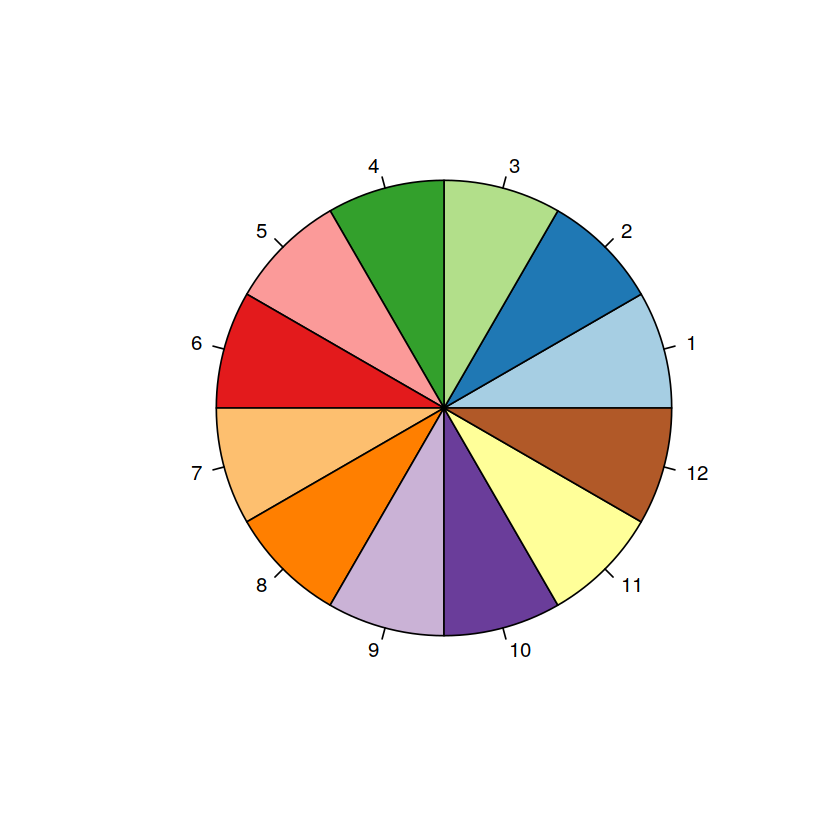

In [5]:
pie(rep(1,12), col=sampleColors) 

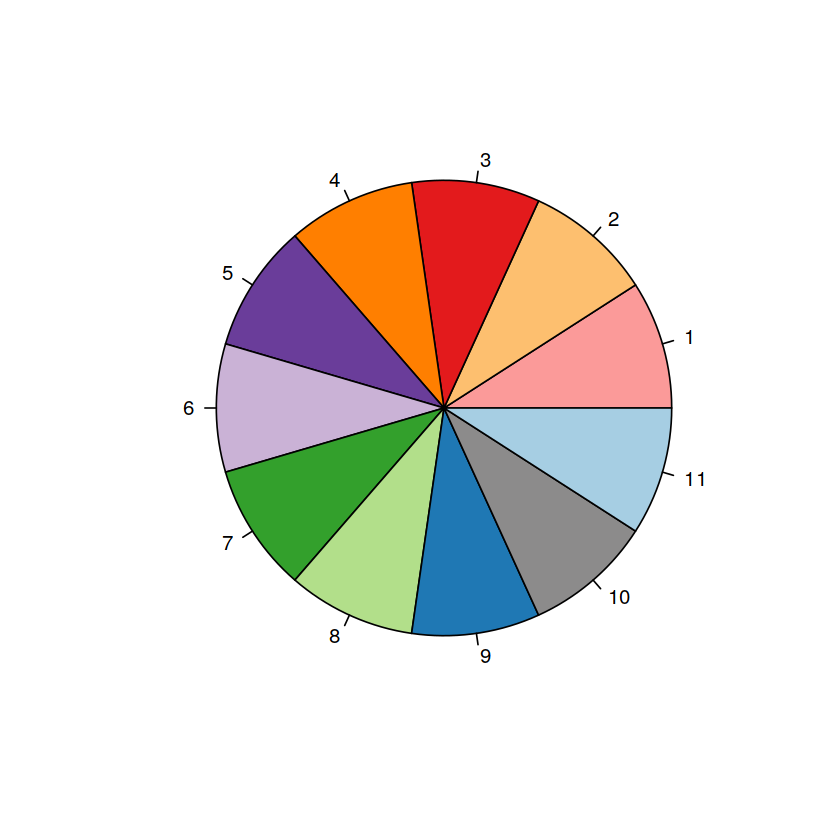

In [6]:
sampleColors <- RColorBrewer::brewer.pal(11,"Paired")
sampleColors[11] <- "#8c8b8b"




# Color patient tumors to resemble the cancer ribbon color 
sampleColors <- c(sampleColors[5],sampleColors[7],sampleColors[6],sampleColors[8],sampleColors[10],sampleColors[9],sampleColors[4],sampleColors[3],sampleColors[2],sampleColors[11],sampleColors[1])

pie(rep(1,11), col=sampleColors) 

## read data

In [7]:
IDs = list.files('data/',pattern = 'gz.mtx')%>%str_extract(('(?<=_).*(?=_ATAC)'))

In [8]:
counts <- readMM("data/peak_calling/merge//all_barcodes.mtx") 

In [9]:
counts%>%dim

[1] 564308  74621

In [10]:
colnames(counts) <- fread('data/peak_calling/merge//all_barcodes.txt',header = FALSE)%>%
                    pull(V1)

rownames(counts) <- fread('data/peak_calling/merge/all_merge.bed')%>%mutate(name=paste0(V1,':',V2,'-',V3))%>%pull(name)

In [11]:
counts[1:3,1:3]

3 x 3 sparse Matrix of class "dgTMatrix"
                   3533EL#TCGGGACAGGATTAAC-1 3533EL#ATTGTGGCAAGTAACA-1
chr1:181343-181675                         .                         .
chr1:184444-184653                         .                         .
chr1:191411-191676                         .                         .
                   3533EL#ACCAAACCACCTGAAT-1
chr1:181343-181675                         .
chr1:184444-184653                         .
chr1:191411-191676                         .

In [12]:
metadata <- fread('data/tumor_metadata_Full_Cohort.tsv')

In [13]:
metadata%>%dim

[1] 74621    20

In [14]:
colnames(metadata)

[1] "Barcode"              "Sample"               "TSSEnrichment"       
 [4] "ReadsInTSS"           "ReadsInPromoter"      "ReadsInBlacklist"    
 [7] "PromoterRatio"        "PassQC"               "NucleosomeRatio"     
[10] "nMultiFrags"          "nMonoFrags"           "nFrags"              
[13] "nDiFrags"             "DoubletScore"         "DoubletEnrichment"   
[16] "BlacklistRatio"       "ATAC_clusters"        "predictedCell_ArchR" 
[19] "predictedGroup_ArchR" "predictedScore_ArchR"

In [15]:
metadata = metadata%>%#dplyr::filter(Sample==sample_name)%>%
        #mutate(Barcode=str_extract(Barcode,'(?<=#).*'))%>%
        column_to_rownames('Barcode')

In [16]:
metadata%>%colnames

[1] "Sample"               "TSSEnrichment"        "ReadsInTSS"          
 [4] "ReadsInPromoter"      "ReadsInBlacklist"     "PromoterRatio"       
 [7] "PassQC"               "NucleosomeRatio"      "nMultiFrags"         
[10] "nMonoFrags"           "nFrags"               "nDiFrags"            
[13] "DoubletScore"         "DoubletEnrichment"    "BlacklistRatio"      
[16] "ATAC_clusters"        "predictedCell_ArchR"  "predictedGroup_ArchR"
[19] "predictedScore_ArchR"

In [17]:
metadata%>%head

,Sample,TSSEnrichment,ReadsInTSS,ReadsInPromoter,ReadsInBlacklist,PromoterRatio,PassQC,NucleosomeRatio,nMultiFrags,nMonoFrags,nFrags,nDiFrags,DoubletScore,DoubletEnrichment,BlacklistRatio,ATAC_clusters,predictedCell_ArchR,predictedGroup_ArchR,predictedScore_ArchR
,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
3533EL#TCGGGACAGGATTAAC-1,3533EL,10.860,17758,18408,915,0.10546700,1,1.9534655,6859,29548,87269,50862,0,1.240124,0.005242411,C13,TACATTCAGCTAGAAT-1_1,1-Endothelia,0.9628742
3533EL#ATTGTGGCAAGTAACA-1,3533EL,8.837,12152,14155,914,0.08188613,1,2.0101696,6652,28713,86431,51066,0,1.000100,0.005287455,C13,CAGTTAGTCGTAATGC-1_1,1-Endothelia,0.9796092
3533EL#ACCAAACCACCTGAAT-1,3533EL,10.446,18638,20871,1142,0.12203693,1,1.6052159,8154,32823,85511,44534,0,0.640064,0.006677503,C5,TGTCCTGGTATTTCCT-1_1,23-Stromal fibroblasts,0.9685782
3533EL#ACCCAAACATCATAGC-1,3533EL,12.533,28279,29701,759,0.17387512,1,0.5723596,4872,54319,85409,26218,0,0.520052,0.004443326,C5,ACCCTCAGTCTCGACG-1_1,23-Stromal fibroblasts,1.0000000
3533EL#GTGACATCAGGTCTGC-1,3533EL,14.787,46307,46532,821,0.27693004,1,0.7406095,6651,48267,84014,29096,0,0.860086,0.004886090,C13,GACTGATTCTGCACCT-1_1,1-Endothelia,0.9975997
3533EL#CCCGTTATCCTAAGTG-1,3533EL,10.252,26203,28160,676,0.17279678,1,0.9976709,6813,40789,81483,33881,0,0.540054,0.004148105,C28,GGGCTCACACGGTGAA-1_1,31-Unciliated epithelia 1,1.0000000


### subset using metadata

In [18]:
counts.sub <- counts[,intersect(rownames(metadata),colnames(counts))]

In [19]:
metadata.sub <- metadata[intersect(rownames(metadata),colnames(counts)),]

In [20]:
counts.sub%>%dim

[1] 564308  74621

## build seurat object

In [21]:
chrom_assay <- CreateChromatinAssay(
  counts = counts.sub,
  sep = c(":", "-"),
  genome = 'hg38',
 # fragments = './data/all/all_barcodes.fragments.tsv.gz',
  min.cells = 0,
  min.features = 0
)


In [22]:
seurat.object.all <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata.sub
)

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [23]:
seurat.object <- subset(seurat.object.all, cells = rownames(metadata.sub))

## Normalize & TF-IDF & SVD
seurat.object <- RunTFIDF(seurat.object)
seurat.object <- FindTopFeatures(seurat.object, min.cutoff = 'q0')
seurat.object <- RunSVD(seurat.object)
p.cor <- DepthCor(seurat.object)

## Clustering &UMAP
suppressMessages({

    seurat.object <- RunUMAP(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, algorithm = 3)

})
## plot
p.umap.cluster = DimPlot(object = seurat.object, label = TRUE) + theme(aspect.ratio = 1)




Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


In [ ]:
#############

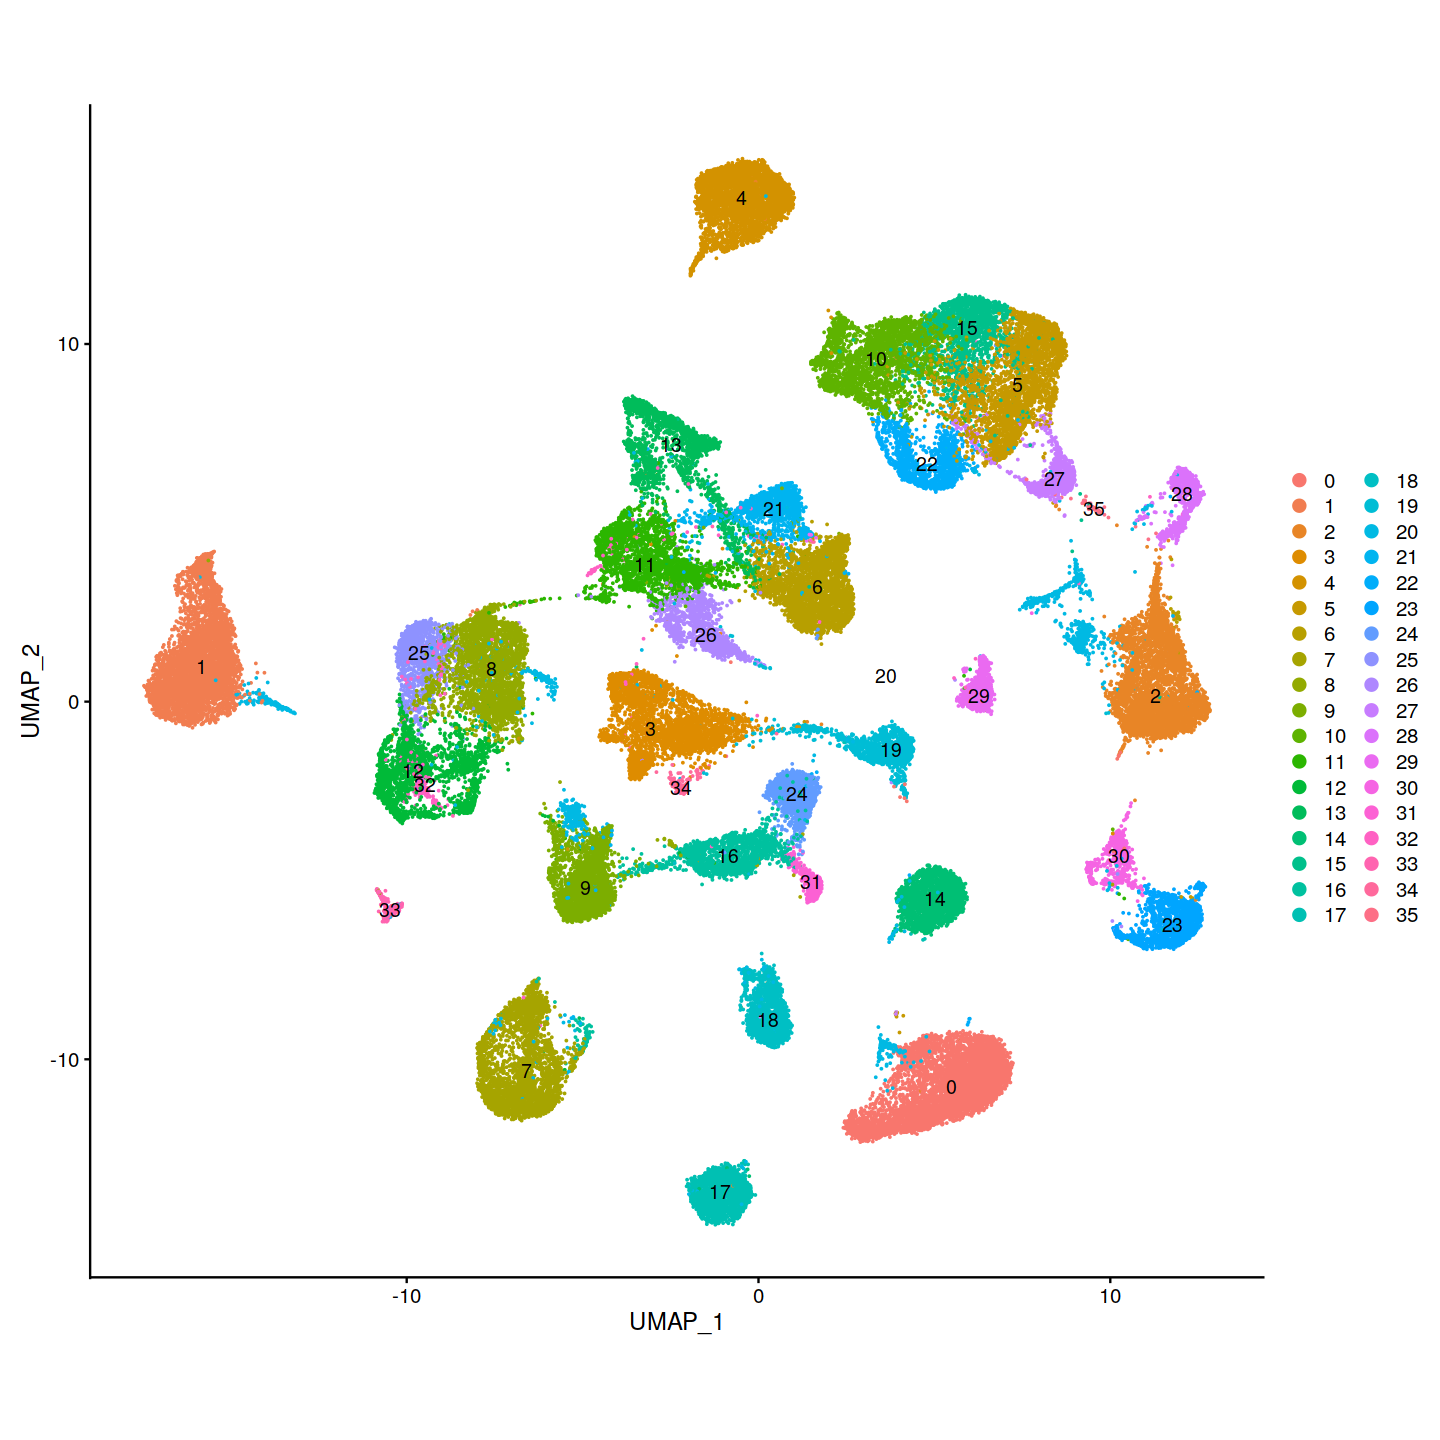

In [25]:
psize(12,12)
p.umap.cluster

In [26]:
# only plot large clusters
cells.sub <- metadata.sub%>%rownames_to_column('cell')%>%group_by(predictedGroup_ArchR)%>%
            mutate(n=n())%>%ungroup%>% dplyr::filter(n>0)%>%pull(cell)
p.umap.label = DimPlot(object = seurat.object,cells = cells.sub, group.by='predictedGroup_ArchR',label = TRUE) + 
                theme(aspect.ratio = 1) 

In [27]:
p.umap.label2 = DimPlot(object = seurat.object,cells = cells.sub, group.by='Sample',label = TRUE) + 
                theme(aspect.ratio = 1) 

In [28]:
psize(15,10)

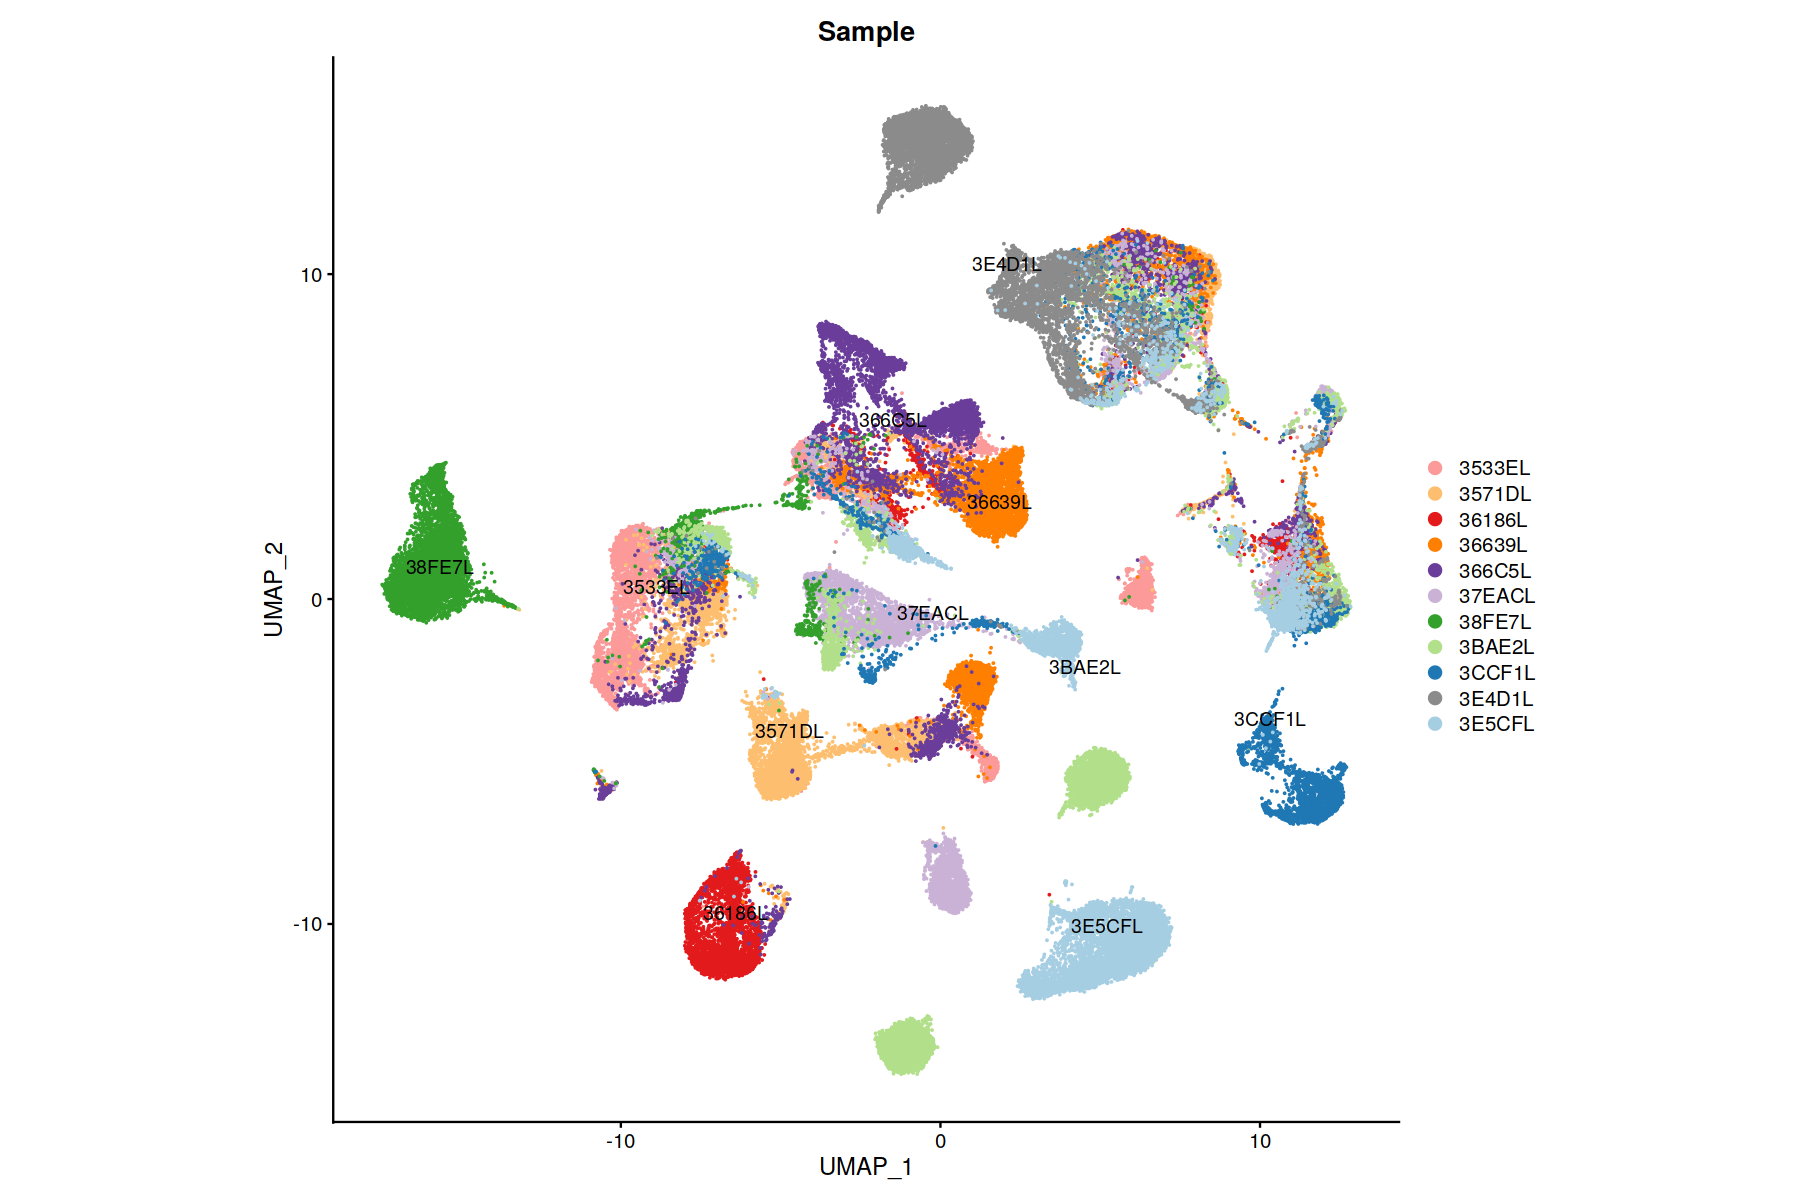

In [29]:
p.umap.label2+scale_color_manual(values=sampleColors)

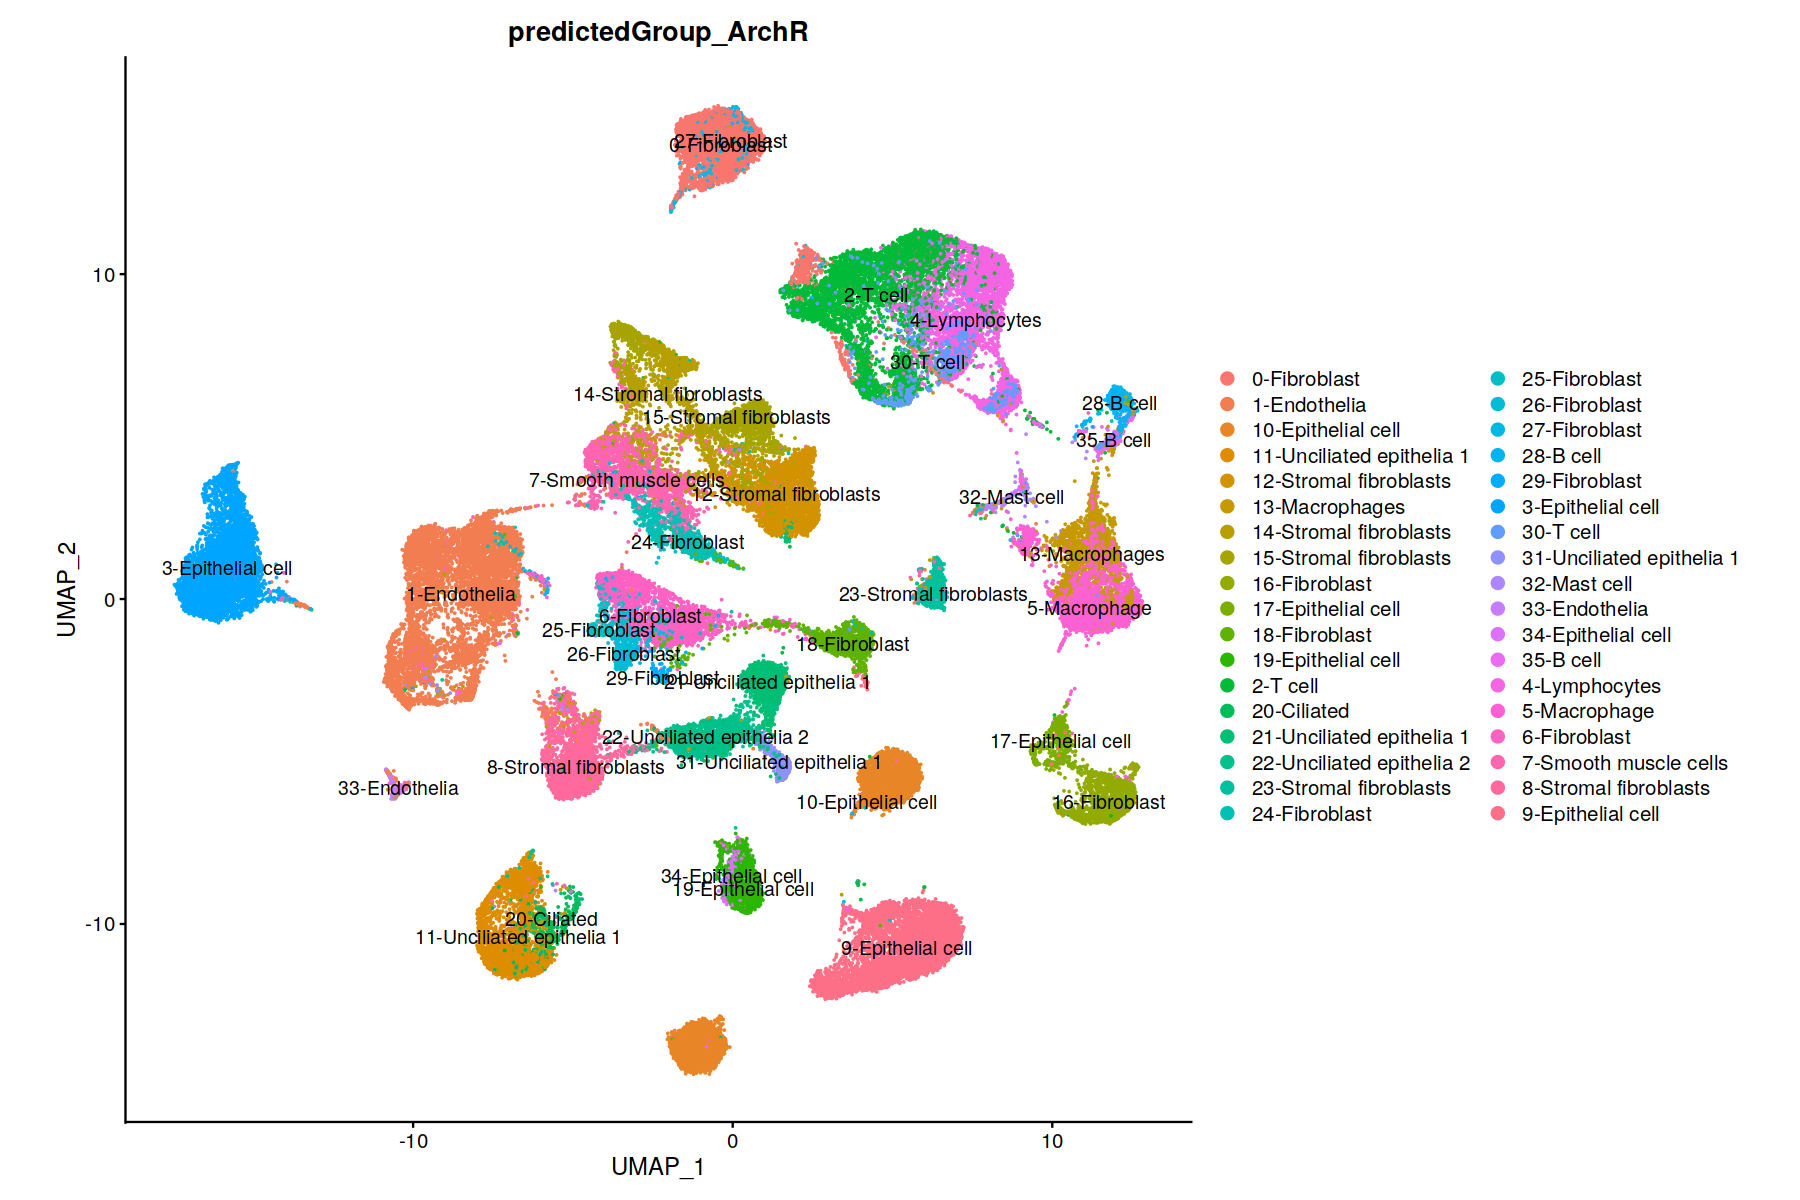

In [30]:
p.umap.label#+scale_color_manual(values=sampleColors)

In [31]:
metadata.rna <- fread('data/tumor_metadata_Full_Cohort_mmc3.tsv')#%>%dplyr::filter(CNV.Pos==TRUE)

In [32]:
    ## add DNA metadata
    metadata.all <- metadata%>%rownames_to_column('ID')%>%
                    left_join(metadata.rna,by=c('predictedCell_ArchR'='Barcode'))%>%column_to_rownames('ID')

    seurat.object@meta.data <-cbind(seurat.object@meta.data,total.cnv=metadata.all$Total_CNVs)
    seurat.object@meta.data <-cbind(seurat.object@meta.data,cnv=metadata.all$CNV.Pos)


    p.umap.cnv = FeaturePlot(object = seurat.object,features='total.cnv',label = FALSE) + theme(aspect.ratio = 1)  
 

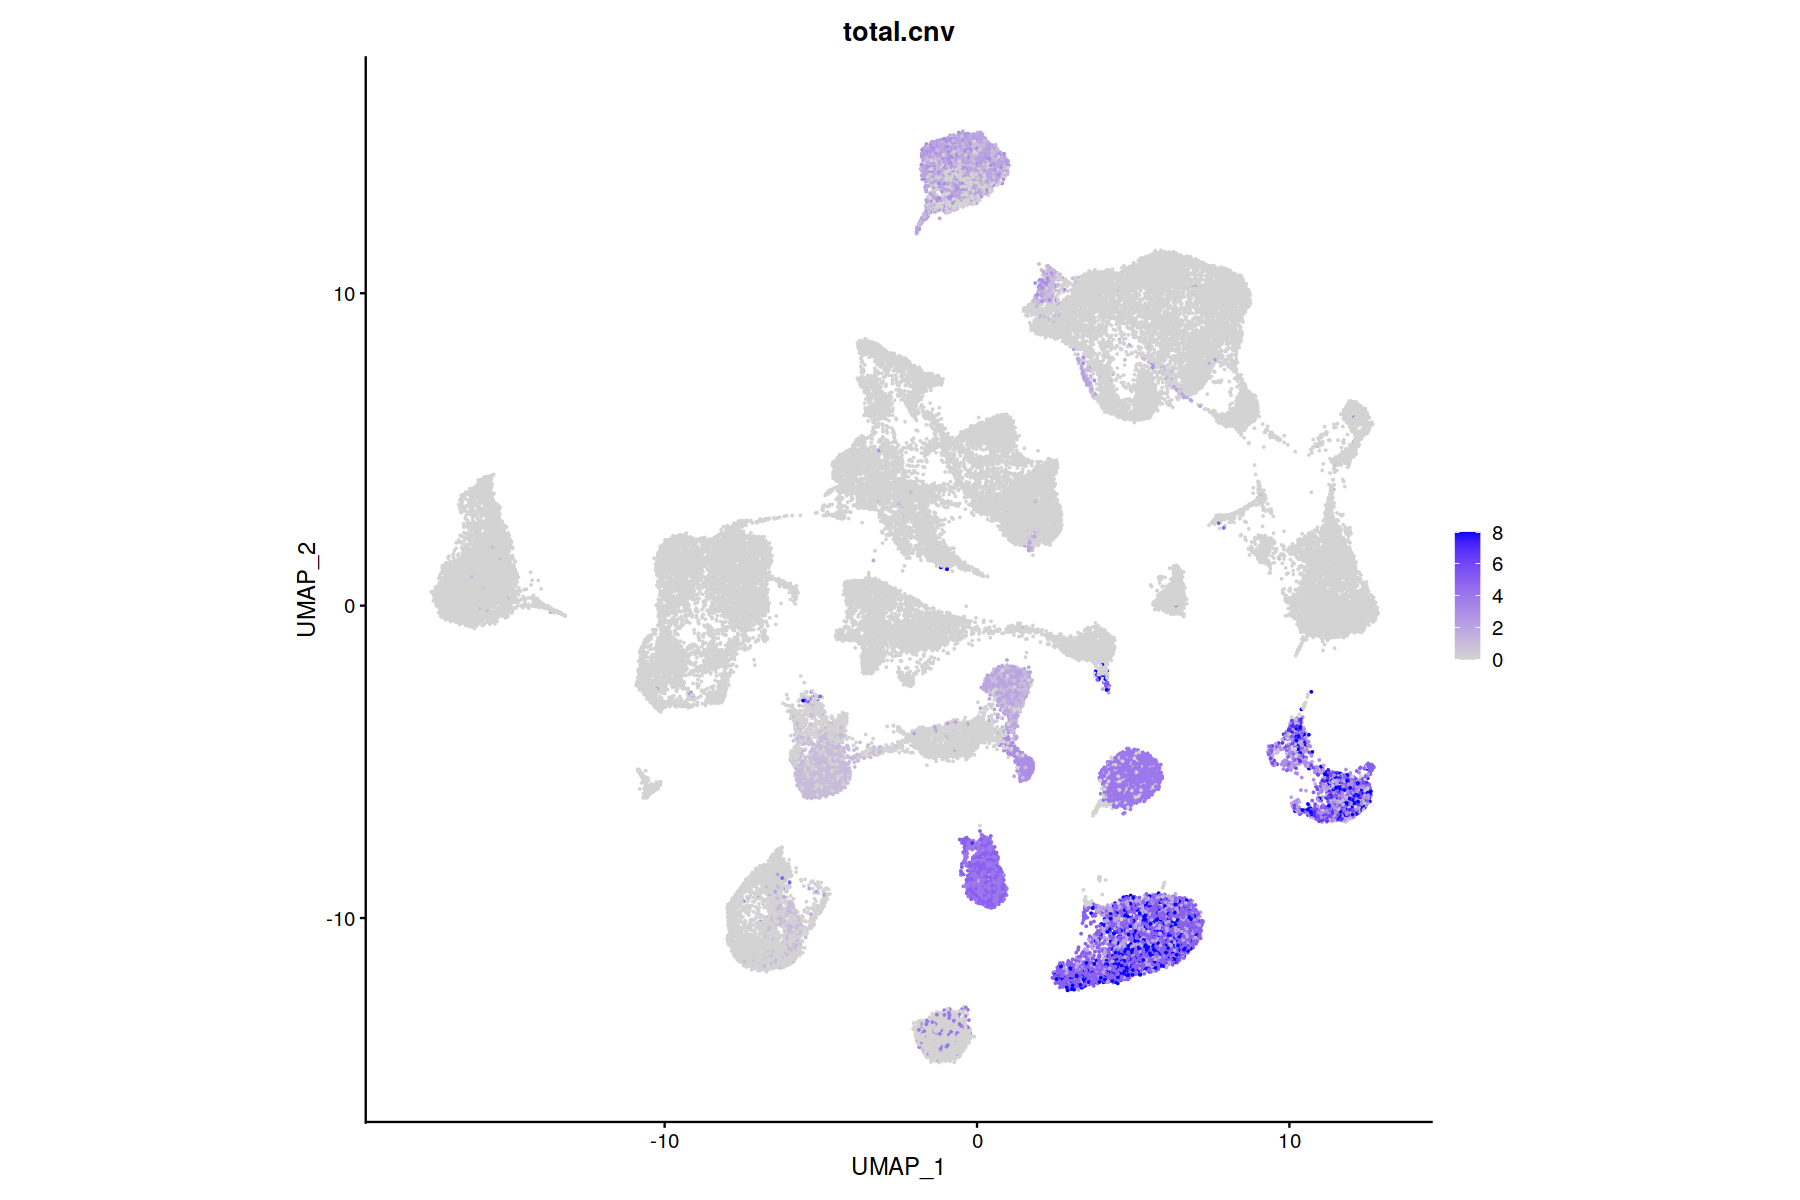

In [42]:
p.umap.cnv

In [34]:
   
    ###################################
    # RNA part

    ## read data
    dir_mtx = list.files('data/rna/all/',pattern = 'mtx')
    dir_barcode = list.files('data/rna/all/',pattern = 'barcodes.txt')
    dir_feature = list.files('data/rna/all/',pattern = 'features')
    counts <- readMM(paste0("data/rna/all/",dir_mtx)) 
    colnames(counts) <- read_table(paste0("data/rna/all/",dir_barcode),col_names  = FALSE,col_types = cols())%>%
                        pull(X1)
    rownames(counts) <- read_table(paste0("data/rna/all/",dir_feature),col_names  = FALSE,col_types = cols())%>%pull(X2)%>%make.unique

In [43]:
colnames(counts)%>%tail

[1] "3E5CFL#TTTGTTGGTCCTTGTC-1" "3E5CFL#TTTGTTGGTCTTTCAT-1"
[3] "3E5CFL#TTTGTTGGTTCCGTTC-1" "3E5CFL#TTTGTTGTCATGAGGG-1"
[5] "3E5CFL#TTTGTTGTCCGTCAAA-1" "3E5CFL#TTTGTTGTCGAGATGG-1"

In [36]:
metadata.rna%>%tail

Barcode,nCount_RNA,nFeature_RNA,RNA_snn_res.0.7,seurat_clusters,PC1.loading,CNV.Pos,Total_CNVs,SingleR,Sample,percent.mt,cell.type
<chr>,<int>,<int>,<int>,<int>,<dbl>,<lgl>,<int>,<chr>,<chr>,<dbl>,<chr>
TTTGTTGAGTTGGACG-1_11,92385,7438,9,9,-9.930240,TRUE,8,Epithelial cell,3E5CFL,6.8679981,9-Epithelial cell
TTTGTTGGTCCTTGTC-1_11,16624,4065,9,9,-6.958114,TRUE,5,Epithelial cell,3E5CFL,3.1520693,9-Epithelial cell
TTTGTTGGTCTTTCAT-1_11,10377,3092,18,18,4.887620,FALSE,0,Fibroblast,3E5CFL,1.9369760,18-Fibroblast
TTTGTTGGTTCCGTTC-1_11,2212,1113,9,9,-3.106266,TRUE,5,Empty/Epithelial cell,3E5CFL,0.2712477,9-Epithelial cell
TTTGTTGTCATGAGGG-1_11,3427,1242,5,5,6.496398,FALSE,0,Macrophage,3E5CFL,4.8730668,5-Macrophage
TTTGTTGTCCGTCAAA-1_11,13284,3209,9,9,-5.624542,TRUE,8,Epithelial cell,3E5CFL,9.5528455,9-Epithelial cell


In [37]:
    ## seurat object
    metadata.rna.sub <- metadata.rna%>%#dplyr::filter(Sample==sample_name)%>%
                        mutate(Barcode=paste0(Sample,'#',gsub('_.$|_..$','',Barcode)))%>%column_to_rownames('Barcode')
    seurat.rna <- CreateSeuratObject(counts = counts, project = "tumor",meta.data = metadata.rna.sub)
    seurat.rna <- subset(seurat.rna, cells = rownames(metadata.rna.sub))
    

In [ ]:
    ## normalize  & scale
    seurat.rna <- NormalizeData(seurat.rna, normalization.method = "LogNormalize", scale.factor = 10000)

    seurat.rna <- FindVariableFeatures(seurat.rna, selection.method = "vst", nfeatures = 2000)

    all.genes <- rownames(seurat.rna)
    seurat.rna <- ScaleData(seurat.rna, features = all.genes)

    ## PCA & UMAP & clustering
    seurat.rna <- RunPCA(seurat.rna, features = VariableFeatures(object = seurat.rna))
    seurat.rna <- RunUMAP(seurat.rna, dims = 1:20)
    seurat.rna <- FindNeighbors(seurat.rna, dims = 1:20)
    seurat.rna <- FindClusters(seurat.rna, resolution = 0.5)

    # plots

    # note that you can set `label = TRUE` or use the LabelClusters function to help label
    # individual clusters
    p.umap.cluster.rna <- DimPlot(seurat.rna, reduction = "umap")

    # note that you can set `label = TRUE` or use the LabelClusters function to help label
    # individual clusters
    p.umap.label.rna <- DimPlot(seurat.rna,group.by = 'cell.type', reduction = "umap",label = TRUE)+theme(aspect.ratio = 1)

    p.umap.cnv.rna <- FeaturePlot(object = seurat.rna,features='Total_CNVs',label = FALSE) +theme(aspect.ratio = 1)

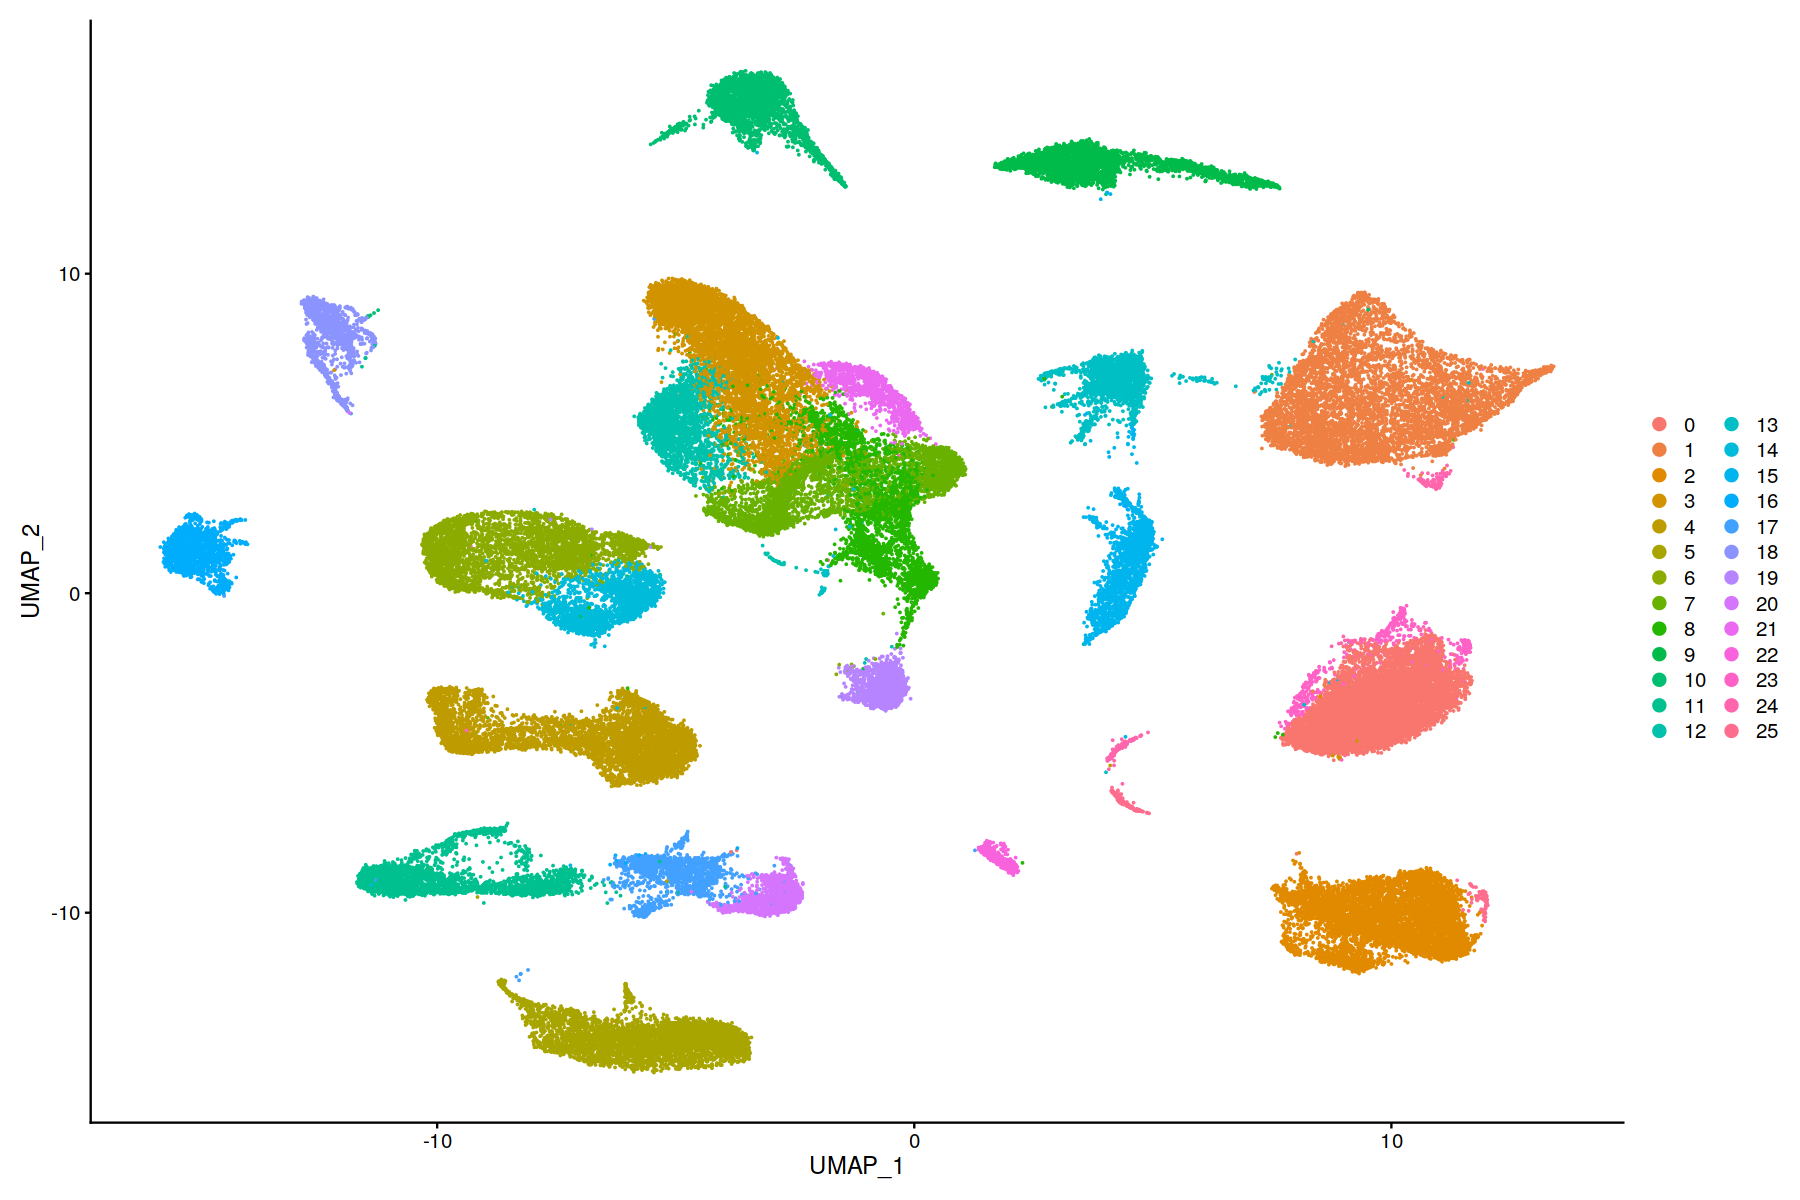

In [47]:
p.umap.cluster.rna

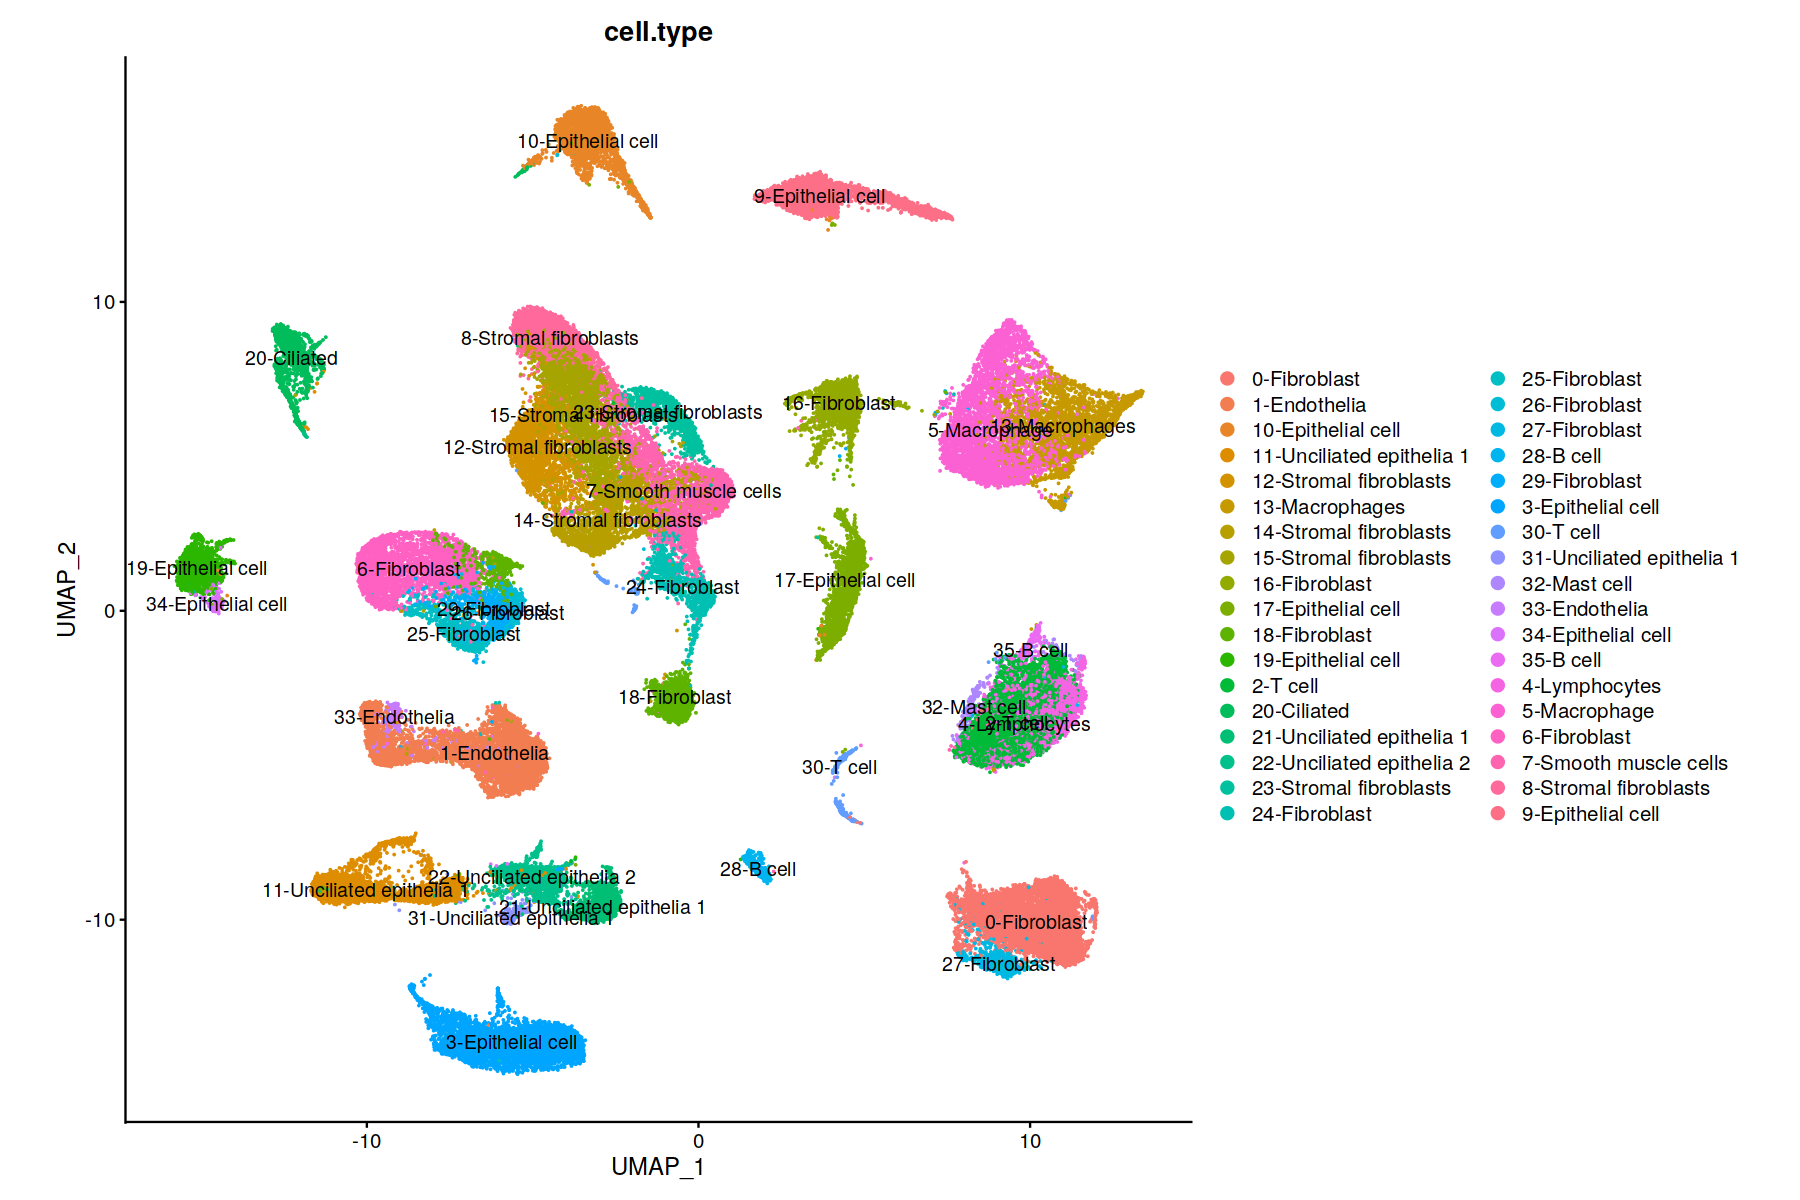

In [40]:
p.umap.label.rna

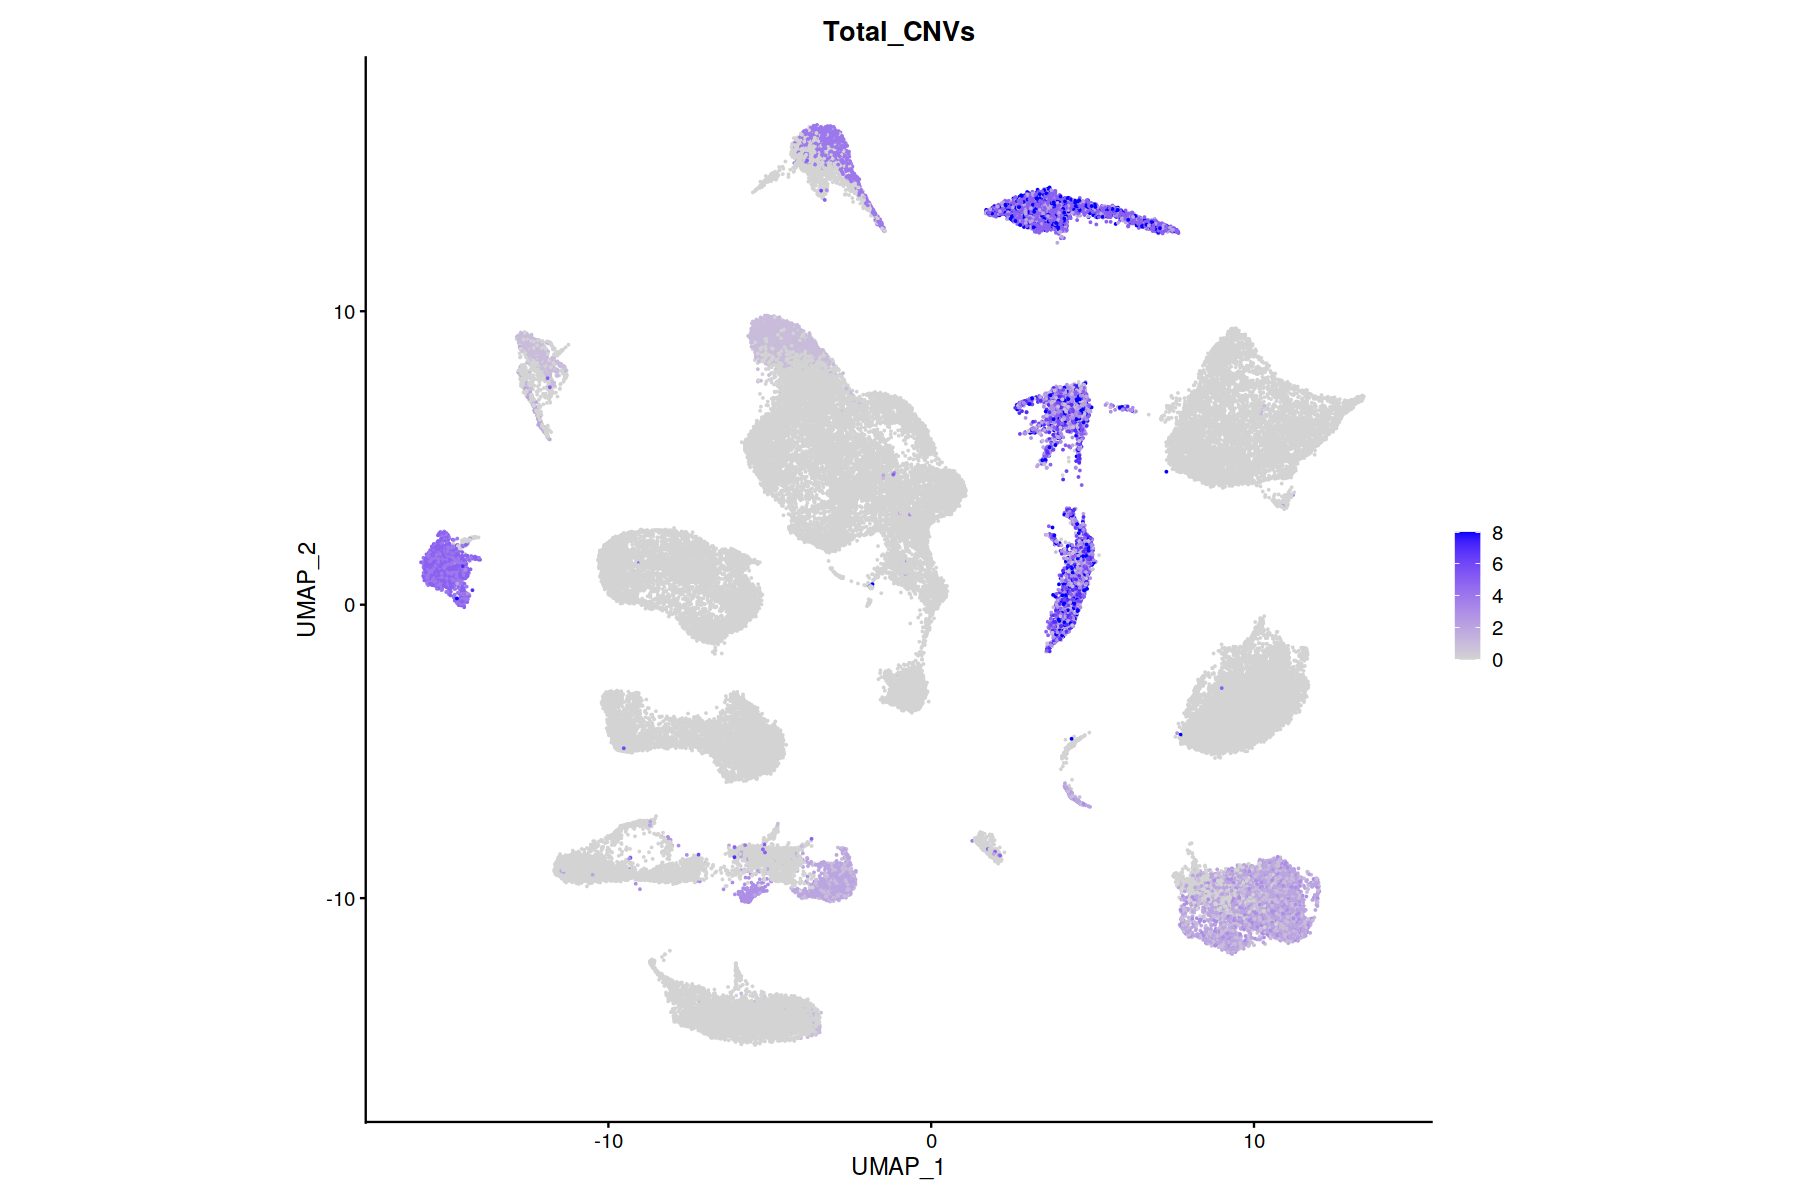

In [41]:
p.umap.cnv.rna

In [49]:
## add Fragments

In [50]:
fragments <- CreateFragmentObject(
  path = './data/all/all_barcodes.fragments.sort.byBash.tsv.gz',
  cells = colnames(seurat.object),
  validate.fragments = FALSE
)
Fragments(seurat.object) <- fragments

Computing hash



In [51]:
   
    ######################################
    ## ATAC gene activity

    # extract gene annotations from EnsDb
    annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86 )



    # # change to UCSC style since the data was mapped to hg19
    seqlevelsStyle(annotations) <- 'UCSC'

    DefaultAssay(seurat.object) <- "peaks"

    # add the gene information to the object
    Annotation(seurat.object) <- annotations

    gene.activities <- GeneActivity(seurat.object)

    # add the gene activity matrix to the Seurat object as a new assay and normalize it
    seurat.object[['RNA']] <- CreateAssayObject(counts = gene.activities)
    seurat.object <- NormalizeData(
      object = seurat.object,
      assay = 'RNA',
      normalization.method = 'LogNormalize',
      scale.factor = median(seurat.object$nCount_RNA)
    )
 

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [ ]:
    ###########################################################
    # link RNA ATAC

    DefaultAssay(seurat.object) <- 'RNA'

    transfer.anchors <- FindTransferAnchors(
      reference = seurat.rna,
      query = seurat.object,
      reduction = 'cca'
    )

    predicted.labels <- TransferData(
      anchorset = transfer.anchors,
      refdata = seurat.rna$cell.type,
      weight.reduction = seurat.object[['lsi']],
      dims = 2:30
    )
    seurat.object <- AddMetaData(object = seurat.object, metadata = predicted.labels)


    plot1 <- DimPlot(
      object = seurat.rna,
      group.by = 'cell.type',
      label = TRUE,
      repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

    plot2 <- DimPlot(
      object = seurat.object,
      group.by = 'predicted.id',
      label = TRUE,
      repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

    plot.join <- (plot1+theme(aspect.ratio = 1)) + ((plot2+theme(aspect.ratio = 1)))

    ## results
    res <- list(metadata.sub = metadata.sub,
                seurat.object=list(atac=seurat.object,rna=seurat.rna), 
                plot=list(p.umap.cluster=p.umap.cluster,
                          p.umap.label=p.umap.label,
                          p.umap.cnv=p.umap.cnv,
                          p.umap.cluster.rna=p.umap.cluster.rna,
                          p.umap.label.rna = p.umap.label.rna,
                          p.umap.cnv.rna=p.umap.cnv.rna,
                          p.join = plot.join))
    ## save all plots
    pdf(paste0('plot/','all','.pdf'),height = 6,width=16)
    (res$plot)%>%print
    dev.off()


Running CCA

Merging objects

Finding neighborhoods



In [ ]:
qsave(res,paste0('rds/peaks/','all_merge','.qs'))

In [ ]:
## save all plots
pdf(paste0('plot/peaks/','all.large.merge','.pdf'),height = 10,width=22)
(res$plot)%>%print
dev.off()

# add other data

In [ ]:
tmp = list(`Endometrial Cancer`=c(11,20,21,22,31,19,34),
    `Ovarian Cancer`=c(3,9,10,16,17),
    `GIST` = c(0,27),
    `Fibroblast/Stromal`=c(6,8,12,14,15,18,24,25,26,29),
    `Smooth Muscle`=c(7,23),
    `Endothelial`=c(1,33),
    `NK/T cell`=c(2,4,30),
    `Macrophage`=c(5,13),
    `Mast`=32,
    `B cell`=c(28,35))

tmp = (tmp%>%unlist%>%as.data.frame%>%rename_with(~c('clusterID'))%>%
       rownames_to_column('celltype')%>%mutate(celltype=gsub('[0-99]$','',celltype)))

In [ ]:
tmp %>%qsave('metadata_trans.qs')

In [ ]:
tmp.meta = seurat.object@meta.data 

In [ ]:
metadata.expand <- seurat.object@meta.data%>%rownames_to_column('a')%>%mutate(clusterID=str_extract(predictedGroup_ArchR,'.*(?=-)')%>%as.numeric,
                                clusterType=str_extract(predictedGroup_ArchR,'(?<=-).*'))%>%
                    left_join(tmp,by=c('clusterID'))%>%column_to_rownames('a')

In [ ]:
seurat.object@meta.data <- metadata.expand

In [ ]:
p.umap.label3 = DimPlot(object = seurat.object,cells = cells.sub, group.by='celltype',label = TRUE) + 
                theme(aspect.ratio = 1) 

In [ ]:
p.umap.label3

In [ ]:
p.umap.label3+scale_color_manual(values=sampleColors)

In [ ]:
p.umap.label4 = DimPlot(object = seurat.object,cells = cells.sub, group.by='clusterID',label = TRUE) + 
                theme(aspect.ratio = 1) 

In [ ]:
p.umap.label4

In [ ]:
DefaultAssay(seurat.object) <- 'RNA'
p.feature.atac = FeaturePlot(seurat.object, features = c('KIT','WFDC2','MUC16'),ncol = 3)#+NoLegend()

p.feature.rna = FeaturePlot(seurat.rna, features = c('KIT','WFDC2','MUC16'),ncol = 3)#+theme(aspect.ratio = 1)

In [ ]:
## results
res <- list(metadata.sub = metadata.sub,
            seurat.object=list(atac=seurat.object,rna=seurat.rna), 
            plot=list(p.umap.cluster=p.umap.cluster,
                      p.umap.label=p.umap.label,
                      p.umap.label2=p.umap.label2,
                      p.umap.label3=p.umap.label3,
                      p.umap.label4=p.umap.label4,
                      p.feature.atac=p.feature.atac,
                      p.feature.rna = p.feature.rna,
                      p.umap.cnv=p.umap.cnv,
                      p.umap.cluster.rna=p.umap.cluster.rna,
                      p.umap.label.rna = p.umap.label.rna,
                      p.umap.cnv.rna=p.umap.cnv.rna,
                      p.join = plot.join))
## save all plots
pdf(paste0('plot/peaks/','all_more.merge','.pdf'),height = 10,width=30)
(res$plot)%>%print
dev.off()


In [ ]:
qsave(res,paste0('rds/peaks/','all_more.merge','.qs'))

In [ ]:
# change back to working with peaks instead of gene activities
DefaultAssay(seurat.object) <- 'peaks'

da_OC_intra <- FindMarkers(group.by = 'peaks_snn_res.0.8',
  object = seurat.object,
  ident.1 = 14,
  ident.2 = 17,
  test.use = 'LR',
  #latent.vars = 'peak_region_fragments'
)


In [ ]:
da_OC_intra%>%qsave('all.da_OC_intra.merge.qs')